# Repeat Analysis
Analyzing the output from `RepeatMasker` to build [repeat landscape plots](http://repeatmasker.org/genomicDatasets/RMGenomicDatasets.html).

## Load packages and define functions

In [39]:
# Core
import re, os, glob
import pandas as pd
from pandas.compat import StringIO
from scipy import stats
import numpy as np
import csv
# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [54]:
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True, seed=None):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks.
    See StackExchange (https://stackoverflow.com/questions/14720331/how-to-generate-random-colors-in-matplotlib)
    for where this originated.
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :param seed: Set random seed for reproducibility
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    np.random.seed(seed=seed)
    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in xrange(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in xrange(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap

## Load data

In [83]:
pamilis_dir = "../Data/RepeatMasker/P_amilis/"
pamilis_rfam = pd.read_csv(glob.glob(datadir+"*.Rfam.tab")[0], sep="\t", skiprows=1)

allmask_dir = "/Users/iangilman/Dropbox/P_amilis_genome_project/RepeatMasker/Viridiplantae_mask_2/"
allmask_rfam = pd.read_csv(glob.glob(allmask_dir+"*.Rfam.tab")[0], sep="\t", skiprows=1)

allmask_rfam.head()

,Rclass,Rfam,[0;1[,[1;2[,[2;3[,[3;4[,[4;5[,[5;6[,[6;7[,[7;8[,...,[40;41[,[41;42[,[42;43[,[43;44[,[44;45[,[45;46[,[46;47[,[47;48[,[48;49[,[49;50[
0,RC,Helitron?,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,DNA,CMC-EnSpm,32,0,0,85,41,77,195,386,...,0,0,0,0,0,0,0,0,0,0
2,LTR,Caulimovirus,63,0,0,55,0,0,61,0,...,0,0,0,0,0,0,0,0,0,0
3,LTR,DIRS,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,LINE,L1-Tx1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


To get it into a form ammenable to repeat landscape plots (i.e. stack barcharts) we'll convert the units of basepairs into fraction of genome, transpose the dataframe, and use the repeat families as columns.

In [84]:
# Rename columns
new_cols = []
for col in pamilis_rfam.columns:
    if col.startswith("["): new_cols.append("-".join(re.findall("\d+", col)))
    else: new_cols.append(col)
pamilis_rfam.columns = new_cols

# Convert to percentages
genome_size = 403885173
pamilis_rfam[pamilis_rfam.select_dtypes(include=['number']).columns] /= genome_size

# Transpose and set families as columns
pamilis_rfam = pamilis_rfam.T[1:]
pamilis_rfam.columns = pamilis_rfam.iloc[0]
pamilis_rfam[1:].reset_index(drop=True)
pamilis_rfam = pamilis_rfam[1:].reset_index(drop=True)

pamilis_rfam.head()

Rfam,Retro,RTE-BovB,Maverick,MULE-MuDR,DNA,LINE,Ginger-1,hAT-hATm,Helitron,CMC-EnSpm,...,L2,nonLTR,hAT,Gypsy,LTR,hAT-Ac,R2-NeSL,hAT-Tag1,Cassandra,Unknown
0,2.42074e-05,2.62451e-06,1.0399e-07,1.5648e-06,0.000100628,0.000299877,6.93266e-08,0,9.68097e-07,2.13947e-05,...,0,5.12522e-07,0,2.03647e-05,5.05243e-05,7.58384e-06,2.79782e-07,0,7.08122e-07,1.21916e-05
1,8.20728e-05,8.19045e-06,0,3.9224e-05,0.000446194,0.000169964,0,0,4.01104e-06,7.66505e-05,...,7.93047e-06,2.23826e-06,0,0.000105926,0.0002062,8.63637e-05,1.33701e-07,5.17474e-07,1.32736e-05,8.39075e-05
2,0.000158723,5.85488e-05,1.18846e-07,0.000107167,0.00066385,0.000207282,1.73317e-07,0,9.78991e-06,0.000121958,...,1.69479e-05,6.02151e-06,8.66583e-08,0.000779472,0.000523837,0.000371457,0,4.0977e-06,4.34381e-05,0.000313163
3,0.000254558,9.15582e-05,0,0.000229261,0.00109742,0.000492286,0,0,2.55568e-05,0.000149245,...,2.74608e-05,2.71488e-05,5.84324e-07,0.00199601,0.000906443,0.000466687,2.57499e-07,1.87628e-05,0.000106478,0.000567963
4,0.000579368,0.000150362,1.06466e-07,0.00017987,0.00178438,0.000788999,2.47595e-07,0,3.94691e-05,0.00017634,...,5.79373e-06,5.69444e-05,5.14998e-07,0.00236067,0.00122912,0.000652227,6.63555e-07,2.06296e-05,0.000180532,0.000713319


In [85]:
# Rename columns
new_cols = []
for col in allmask_rfam.columns:
    if col.startswith("["): new_cols.append("-".join(re.findall("\d+", col)))
    else: new_cols.append(col)
allmask_rfam.columns = new_cols

# Convert to percentages
genome_size = 403885173
allmask_rfam[allmask_rfam.select_dtypes(include=['number']).columns] /= genome_size

# Transpose and set families as columns
allmask_rfam = allmask_rfam.T[1:]
allmask_rfam.columns = allmask_rfam.iloc[0]
allmask_rfam[1:].reset_index(drop=True)
allmask_rfam = allmask_rfam[1:].reset_index(drop=True)

allmask_rfam.head()

Rfam,Helitron?,CMC-EnSpm,Caulimovirus,DIRS,L1-Tx1,RTE-derived,Dualen,Copia,DNA?,Cassandra,...,PIF-Harbinger?,tRNA-RTE,tRNA,Retroposon,L1,Copia?,hAT-Ac,CRE,PIF-Harbinger,P
0,0,7.92304e-08,1.55985e-07,0,0,0,0,4.30816e-07,0,0,...,0,0,0,0,6.68507e-08,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,4.48147e-07,0,0,...,0,0,0,0,2.97114e-07,8.66583e-08,0,0,0,0
3,0,2.10456e-07,1.36177e-07,0,0,0,0,6.95742e-07,0,0,...,0,0,0,0,2.92162e-07,0,6.68507e-08,0,0,0
4,0,1.01514e-07,0,0,0,0,0,6.9079e-07,0,0,...,0,0,0,0,1.11418e-07,0,0,0,0,0


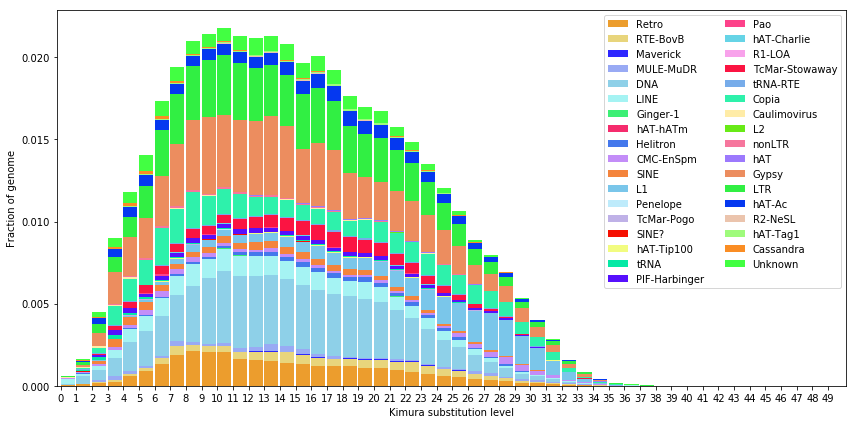

In [86]:
fig, ax = plt.subplots(figsize=(12,6))

mycmap = rand_cmap(nlabels=len(pamilis_rfam.columns), first_color_black=False, 
                   last_color_black=False, verbose=False, seed=19)

pamilis_rfam.plot.bar(stacked=True, ax = ax, align="edge", width=0.9, colormap=mycmap)
plt.legend(loc="upper right", ncol=2, fancybox=True)

ax.set_ylabel("Fraction of genome")
ax.set_xlabel("Kimura substitution level")

plt.xticks(rotation=0)
plt.tight_layout()
# plt.savefig("../Figures/P_amilis.repeatlandscape.pdf", dpi = 100, transparent=True)

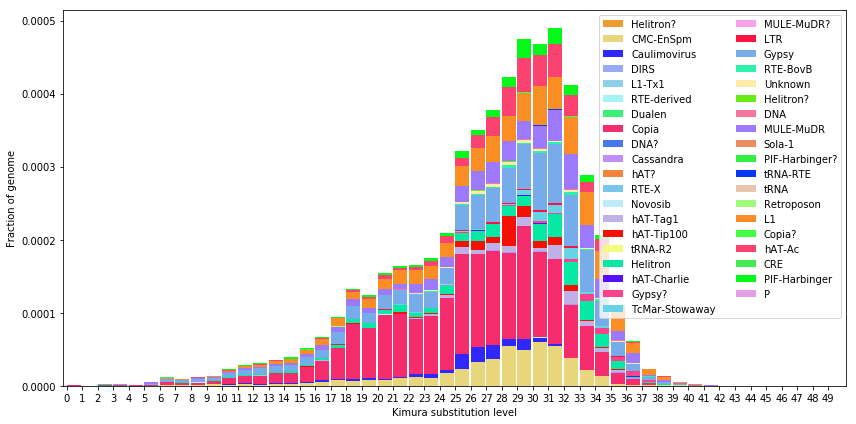

In [87]:
fig, ax = plt.subplots(figsize=(12,6))

mycmap = rand_cmap(nlabels=len(allmask_rfam.columns), first_color_black=False, 
                   last_color_black=False, verbose=False, seed=19)

allmask_rfam.plot.bar(stacked=True, ax = ax, align="edge", width=0.9, colormap=mycmap)
plt.legend(loc="upper right", ncol=2, fancybox=True)

ax.set_ylabel("Fraction of genome")
ax.set_xlabel("Kimura substitution level")

plt.xticks(rotation=0)
plt.tight_layout()
# plt.savefig("../Figures/P_amilis.repeatlandscape.pdf", dpi = 100, transparent=True)

### Fixing a broken `.gff` file
The `.gff` output by MAKER looks like 
```bash
##gff-version 3
Scaffold_27%3BHRSCAF%3D30	.	contig	1	3334	.	.	.	ID=Scaffold_27%3BHRSCAF%3D30;Name=Scaffold_27%3BHRSCAF%3D30
###
Scaffold_27%3BHRSCAF%3D30	repeat_gff:repeatmasker	match	12	199	1173	-	.	ID=Scaffold_27%3BHRSCAF%3D30:hit:39:1.3.0.0;Name=342270;Target=342270 69 250 +
Scaffold_27%3BHRSCAF%3D30	repeat_gff:repeatmasker	match_part	12	199	1173	-	.	ID=Scaffold_27%3BHRSCAF%3D30:hsp:39:1.3.0.0;Parent=Scaffold_27%3BHRSCAF%3D30:hit:39:1.3.0.0;Target=342270 69 250 +
Scaffold_27%3BHRSCAF%3D30	repeat_gff:repeatmasker	match	374	3334	8096	+	.	ID=Scaffold_27%3BHRSCAF%3D30:hit:40:1.3.0.0;Name=342274;Target=342274 2731 3807 +
Scaffold_27%3BHRSCAF%3D30	repeat_gff:repeatmasker	match_part	374	3334	8096	+	.	ID=Scaffold_27%3BHRSCAF%3D30:hsp:40:1.3.0.0;Parent=Scaffold_27%3BHRSCAF%3D30:hit:40:1.3.0.0;Target=342274 2731 3807 +
###
Scaffold_3644%3BHRSCAF%3D4225	.	contig	1	1478	.	.	.	ID=Scaffold_3644%3BHRSCAF%3D4225;Name=Scaffold_3644%3BHRSCAF%3D4225
```
which has scaffold identifies that do not match the headers from `fasta` portion:
```bash
>Scaffold_402;HRSCAF=467
CGTGGATGCACCACCTTTTAAATTATGATCAAGTAGCAAACTTCAATTGGGCATCGGCTA...
>Scaffold_1436;HRSCAF=1659
ATCACCATGAGTGTAAATGCCTTATGGGAAGATCACGATGAAGAGGTTCTAGAGATCAGC...
>Scaffold_695;HRSCAF=808
GAATTCGCCAAATATCGAATGTAATTCGAGCGACGCCTAAATGATGACTTTTCATTGCGA...
>Scaffold_2264;HRSCAF=2617
GAAAGCTTCTGATTTTTCCTGCAAGAAATAGACCCAAGTCTTTCGAGAAAAATCATCAAT...
```

I'm going to try a little regex work to convert something like `Scaffold_27%3BHRSCAF%3D30` to `Scaffold_27;HRSCAF=30` and see if this solves downstream problems.

In [91]:
broken_path = "/Users/iangilman/Dropbox/P_amilis_genome_project/MAKER_single_core/Broken.gff"
with open (broken_path, "r") as b:
    brokenlines = b.readlines()
brokenlines[:5]

['##gff-version 3\n',
 'Scaffold_27%3BHRSCAF%3D30\t.\tcontig\t1\t3334\t.\t.\t.\tID=Scaffold_27%3BHRSCAF%3D30;Name=Scaffold_27%3BHRSCAF%3D30\n',
 '###\n',
 'Scaffold_27%3BHRSCAF%3D30\trepeat_gff:repeatmasker\tmatch\t12\t199\t1173\t-\t.\tID=Scaffold_27%3BHRSCAF%3D30:hit:39:1.3.0.0;Name=342270;Target=342270 69 250 +\n',
 'Scaffold_27%3BHRSCAF%3D30\trepeat_gff:repeatmasker\tmatch_part\t12\t199\t1173\t-\t.\tID=Scaffold_27%3BHRSCAF%3D30:hsp:39:1.3.0.0;Parent=Scaffold_27%3BHRSCAF%3D30:hit:39:1.3.0.0;Target=342270 69 250 +\n']

In [98]:
scaffsplits = [line.split("\t") for line in brokenlines if line.startswith("Scaffold")]
scaffsplits[:3]

[['Scaffold_27%3BHRSCAF%3D30',
  '.',
  'contig',
  '1',
  '3334',
  '.',
  '.',
  '.',
  'ID=Scaffold_27%3BHRSCAF%3D30;Name=Scaffold_27%3BHRSCAF%3D30\n'],
 ['Scaffold_27%3BHRSCAF%3D30',
  'repeat_gff:repeatmasker',
  'match',
  '12',
  '199',
  '1173',
  '-',
  '.',
  'ID=Scaffold_27%3BHRSCAF%3D30:hit:39:1.3.0.0;Name=342270;Target=342270 69 250 +\n'],
 ['Scaffold_27%3BHRSCAF%3D30',
  'repeat_gff:repeatmasker',
  'match_part',
  '12',
  '199',
  '1173',
  '-',
  '.',
  'ID=Scaffold_27%3BHRSCAF%3D30:hsp:39:1.3.0.0;Parent=Scaffold_27%3BHRSCAF%3D30:hit:39:1.3.0.0;Target=342270 69 250 +\n']]

In [105]:
target = "Scaffold_27%3BHRSCAF%3D30"
goal = "Scaffold_27;HRSCAF=30"

In [109]:
print brokenlines[1]
print re.sub(pattern=r"(Scaffold_[\d]+)%3BHRSCAF%3D([\d]+)", repl=r"\1;HRSCAF=\2",string=brokenlines[1])

Scaffold_27%3BHRSCAF%3D30	.	contig	1	3334	.	.	.	ID=Scaffold_27%3BHRSCAF%3D30;Name=Scaffold_27%3BHRSCAF%3D30

Scaffold_27;HRSCAF=30	.	contig	1	3334	.	.	.	ID=Scaffold_27;HRSCAF=30;Name=Scaffold_27;HRSCAF=30



In [110]:
def gff_line_fixer(line):
    return re.sub(pattern=r"(Scaffold_[\d]+)%3BHRSCAF%3D([\d]+)", repl=r"\1;HRSCAF=\2", string=line)

In [111]:
fixedlines = [gff_line_fixer(line) for line in brokenlines]

In [112]:
fixedlines

['##gff-version 3\n',
 'Scaffold_27;HRSCAF=30\t.\tcontig\t1\t3334\t.\t.\t.\tID=Scaffold_27;HRSCAF=30;Name=Scaffold_27;HRSCAF=30\n',
 '###\n',
 'Scaffold_27;HRSCAF=30\trepeat_gff:repeatmasker\tmatch\t12\t199\t1173\t-\t.\tID=Scaffold_27;HRSCAF=30:hit:39:1.3.0.0;Name=342270;Target=342270 69 250 +\n',
 'Scaffold_27;HRSCAF=30\trepeat_gff:repeatmasker\tmatch_part\t12\t199\t1173\t-\t.\tID=Scaffold_27;HRSCAF=30:hsp:39:1.3.0.0;Parent=Scaffold_27;HRSCAF=30:hit:39:1.3.0.0;Target=342270 69 250 +\n',
 'Scaffold_27;HRSCAF=30\trepeat_gff:repeatmasker\tmatch\t374\t3334\t8096\t+\t.\tID=Scaffold_27;HRSCAF=30:hit:40:1.3.0.0;Name=342274;Target=342274 2731 3807 +\n',
 'Scaffold_27;HRSCAF=30\trepeat_gff:repeatmasker\tmatch_part\t374\t3334\t8096\t+\t.\tID=Scaffold_27;HRSCAF=30:hsp:40:1.3.0.0;Parent=Scaffold_27;HRSCAF=30:hit:40:1.3.0.0;Target=342274 2731 3807 +\n',
 '###\n',
 'Scaffold_3644;HRSCAF=4225\t.\tcontig\t1\t1478\t.\t.\t.\tID=Scaffold_3644;HRSCAF=4225;Name=Scaffold_3644;HRSCAF=4225\n',
 '###\n',
 'Sc

In [117]:
k = broken_path.rfind(".gff")
print broken_path[:k]+".fixed.gff"

/Users/iangilman/Dropbox/P_amilis_genome_project/MAKER_single_core/Broken.fixed.gff


In [120]:
len(brokenlines)

100

In [121]:
len(fixedlines)

100